# This Notebook is for analyzing and processing the output of scrap

Context: Given the significant number of jobs on the LinkedIn site, it isn't easy to do an accurate search.
The search needs to be more precise, even with the site's filters.
With this, we captured this data to develop more precise ways of searching for the perfect match job.  


Solution: Scrap all job data on the LinkedIn site automatically. After collecting the data, try to develop a way to improve the search for relevant opportunities in a personalized way for each profile.  


# Libs

In [1]:
import pandas as pd
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import gensim
from gensim import corpora

c:\Users\55249\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# Variables

In [2]:
#raw
all_links_path = '../data/raw/all_links.json'
all_jobs_details_path = 'data/raw/all_jobs_detail.json'
all_dirty_data_path = '../data/raw/colect_all_job_dirty_data_slow_all.json'

In [3]:
#wrangle
wrangled_data_path = '../data/wrangle/df_cleaned.csv'

# Functions

In [7]:
def clean_column_strings(df):
    """Clean each column of a dirty dataframe

    Args:
        df (dataframe): dataframe to be clean

    Returns:
        dataframe: cleaned dataframe
    """
    
    df['location'] = df['location'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['company_name'] = df['company_name'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['experience_required'] = df['experience_required'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['contract_type'] = df['contract_type'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['function_name'] = df['function_name'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['company_sector'] = df['company_sector'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    clean = re.compile('<.*?>')
    df['description'] = df['description'].apply(lambda x: re.sub(clean, '', x[0]).replace('\n','').strip())
    df['description'] = df['description'].apply(lambda x: word_split(x))
    
    return df

In [8]:
def word_split(text):
    """Split some words that are imprecisaly toguether after scrap

    Args:
        text (string): string to process

    Returns:
        string: string processed
    """
    # replaces each uppercase letter with a space followed by the same lower case letter
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    return text.strip()



In [9]:
def calculate_na_proportion(df):
    """Build a dataframe with some information about null values on the dataframe

    Args:
        df (dataframe): dataframe to calculate

    Returns:
        dataframe: dataframe with null proportions
    """

    # exploratory DF with % NA and types values
    na_proportion = pd.DataFrame({'name' : df.columns, 'type' : df.dtypes,
                            'NA #': df.isna().sum(), 'NA %' : (df.isna().sum() / df.shape[0]) * 100})
    return na_proportion

# Loading data

In [44]:
with open(all_links_path, 'r') as openfile:
        #Reading from json file
        all_links = json.load(openfile)

In [45]:
with open(all_jobs_details_path, 'r') as openfile:
        #Reading from json file
        data_job = json.load(openfile)

In [122]:
with open(all_dirty_data_path, 'r') as openfile:
        #Reading from json file
        durty_data_job = json.load(openfile)

In [4]:
df_cleaned = pd.read_csv(wrangled_data_path)

# Wrangle data experiments

### Logic for capture job ids in urls

In [31]:
all_links[0]['links']

['https://www.linkedin.com/jobs/view/senior-data-scientist-at-tala-3338538962?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=itkVQcypfASexZhU95Tt5g%3D%3D&position=1&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'https://www.linkedin.com/jobs/view/senior-data-scientist-kpm-p3723-at-84-51%CB%9A-3314238897?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=KHI3nickYQBR7OeopQDj3g%3D%3D&position=2&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'https://www.linkedin.com/jobs/view/lead-data-scientist-p3719-at-84-51%CB%9A-3314239209?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=zcJINMCFRhLTJRmOCyGqhw%3D%3D&position=3&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'https://www.linkedin.com/jobs/view/software-engineer-developer-productivity-at-stem-inc-3377674000?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=kAhiDeiBwGKMhhlRVAY9og%3D%3D&position=4&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'https://www.linkedin.com/jobs/view/software-engineer-big-data-at-pinterest-3453

In [32]:
all_links[0]['links'][0]

'https://www.linkedin.com/jobs/view/senior-data-scientist-at-tala-3338538962?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=itkVQcypfASexZhU95Tt5g%3D%3D&position=1&pageNum=0&trk=public_jobs_jserp-result_search-card'

In [33]:
unique_link = all_links[0]['links'][0]

In [34]:
# It will work, considering that every Job id will always have ten characters
re.findall(r'\d{10}', unique_link)[0]

'3338538962'

In [35]:
#capturing all Job Ids in url
all_ids = []
for l in all_links[0]['links']:
    unique_id = re.findall(r'\d{10}', l)[0]
    all_ids.append(unique_id)

In [36]:
all_ids

['3338538962',
 '3314238897',
 '3314239209',
 '3377674000',
 '3453529654',
 '3314238949',
 '3314236535',
 '3453526797',
 '3314238945',
 '3314239198',
 '3314239195',
 '3314233697',
 '3458419440',
 '3452289200',
 '3451507215',
 '3215796936',
 '3459196895',
 '3453567797',
 '3439168848',
 '2925991336',
 '3403509733',
 '3405457294',
 '3390029031',
 '3344168805',
 '3439171495']

### Clean durty data

In [123]:
df_job = pd.json_normalize(durty_data_job)

In [124]:
df_job = clean_column_strings(df_job)

### Saving cleaned data

In [126]:
df_job.to_csv('../data/wrangle/df_cleaned.csv', index=False)

# Data job Analysis

In [ ]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [10]:
df_job = df_cleaned.copy()

In [11]:
df_job

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link
0,Sr. Data Scientist,"Hershey, PA",PRI Global,Sr. Data Scientist,Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting,Job Description Summary:The Enterprise Data Sc...,https://www.linkedin.com/jobs/view/3478366331
1,Full Stack Java Developer,"Columbia, SC",SPECTRAFORCE,Full Stack Java Developer,Mid-Senior level,Contract,Information Technology,Staffing and Recruiting,Job Title: Full Stack Java Developer Location:...,https://www.linkedin.com/jobs/view/3478344435
2,Senior Full Stack Developer,United States,Optomi,Senior Full Stack Developer,Mid-Senior level,Contract,Information Technology and Engineering,"IT Services and IT Consulting, Computer Hardwa...",Senior Full Stack Developer (Angular/Java/AWS)...,https://www.linkedin.com/jobs/view/3471538079
3,UI Developer,United States,eTeam,UI Developer,Mid-Senior level,Contract,Finance and Sales,Staffing and Recruiting,Job Title: UI Developer Duration: 08+ Months+ ...,https://www.linkedin.com/jobs/view/3475030934
4,Software Engineer II,"Minneapolis, MN",Maxonic,Software Engineer II,Mid-Senior level,Contract,Information Technology,IT Services and IT Consulting,Maxonic is supporting our direct client to ful...,https://www.linkedin.com/jobs/view/3468540882
...,...,...,...,...,...,...,...,...,...,...
977,PL/SQL Developer (w2),United States,Creospan Inc.,PL/SQL Developer (w2),Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting,1) Primary requirement is to get understanding...,https://www.linkedin.com/jobs/view/3489100591
978,Senior Migration Engineer,United States,Syrinx Consulting,Senior Migration Engineer,Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting,Senior Migration Engineer This role is 100% re...,https://www.linkedin.com/jobs/view/3437087146
979,Data Analyst,United States,Mican Technologies Inc.,Data Analyst,Mid-Senior level,Contract,Information Technology,Hospitals and Health Care,"Data Analysts are accountable for assessment, ...",https://www.linkedin.com/jobs/view/3498767112
980,Sr Curam Developer - Triage (Remote),"Washington, DC",Serigor Inc,Sr Curam Developer - Triage (Remote),Mid-Senior level,Contract,Information Technology,IT Services and IT Consulting,Job Title: Sr Curam Developer - Triage (Remote...,https://www.linkedin.com/jobs/view/3496049319


In [12]:
calculate_na_proportion(df_job)

,name,type,NA #,NA %
title,title,object,0,0.0
location,location,object,0,0.0
company_name,company_name,object,0,0.0
position_name,position_name,object,0,0.0
experience_required,experience_required,object,0,0.0
contract_type,contract_type,object,0,0.0
function_name,function_name,object,0,0.0
company_sector,company_sector,object,0,0.0
description,description,object,0,0.0
link,link,object,0,0.0


In [13]:
key_word_ml = 'machine learning'
key_word_ds = 'data scientist'


# check if a column contain a word
ml_patern = re.compile(rf'\b{re.escape(key_word_ml)}\b', flags=re.IGNORECASE)
ds_patern = re.compile(rf'\b{re.escape(key_word_ds)}\b', flags=re.IGNORECASE)

In [14]:
df_target = df_job.loc[(df_job['position_name'].str.contains(ds_patern)) | (df_job['position_name'].str.contains(ml_patern)) ]

In [18]:
#df_target.to_csv('../data/wrangle/df_target.csv',index=False)

In [16]:
total_number_of_targets_scraped =df_target.count()[0]
total_number_of_targets_scraped

48

In [134]:
total_number_of_data_scraped = df_job.count()[0]
total_number_of_data_scraped

982

In [135]:
#proportion of durty data scraped
(total_number_of_data_scraped - total_number_of_targets_scraped) / total_number_of_data_scraped

0.9511201629327902

The targets that have the best matches are in the first positions, but Linkedin sends a lot of unrelated jobs after that that are noncorrelated to the target search

In [136]:
# positions names related with target
df_target

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link
0,Sr. Data Scientist,"Hershey, PA",PRI Global,Sr. Data Scientist,Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting,Job Description Summary:The Enterprise Data Sc...,https://www.linkedin.com/jobs/view/3478366331
16,100% Remote - Sr. Data Scientist / Data Engine...,United States,Dice,100% Remote - Sr. Data Scientist / Data Engine...,Mid-Senior level,Contract,Engineering and Information Technology,"Technology, Information and Internet",Dice is the leading career destination for tec...,https://www.linkedin.com/jobs/view/3478375375
17,Sr Machine Learning Engineer,United States,Burtch Works,Sr Machine Learning Engineer,Mid-Senior level,Contract,Engineering,Software Development,Senior Machine Learning Engineer As a Senior M...,https://www.linkedin.com/jobs/view/3184133160
18,Sr. Data Scientist,United States,Insight Global,Sr. Data Scientist,Mid-Senior level,Contract,Information Technology,Broadcast Media Production and Distribution an...,Position: Sr. Data Scientist Duration: 12 mon...,https://www.linkedin.com/jobs/view/3472342299
20,Senior Machine Learning Engineer,"New York, United States",InterEx Group,Senior Machine Learning Engineer,Mid-Senior level,Contract,Engineering and Information Technology,Staffing and Recruiting,Senior Role The ideal candidate's favourite wo...,https://www.linkedin.com/jobs/view/3476849156
21,Lead Data Scientist,United States,Revolution Technologies,Lead Data Scientist,Mid-Senior level,Contract,Engineering and Information Technology,Staffing and Recruiting,Rev Up Your Career as a Data Scientist Job Tit...,https://www.linkedin.com/jobs/view/3475123003
23,Senior Machine Learning Engineer,"New York, NY",Burtch Works,Senior Machine Learning Engineer,Mid-Senior level,Contract,"Information Technology, Engineering, and Research","IT Services and IT Consulting, Software Develo...",Job Description: Senior Machine Learning Engi...,https://www.linkedin.com/jobs/view/3472314248
24,Machine Learning Ops Engineer,"Austin, TX",Wimmer Solutions,Machine Learning Ops Engineer,Mid-Senior level,Contract,Information Technology,Machinery Manufacturing,Machine Learning Ops Engineer- Remote Client L...,https://www.linkedin.com/jobs/view/3348098378
25,Senior Machine Learning Engineer,"Durham, NC",Vector Technologies LLC,Senior Machine Learning Engineer,Mid-Senior level,Contract,Engineering and Information Technology,Financial Services,Title: Senior Machine Learning Engineer Locati...,https://www.linkedin.com/jobs/view/3473341847
27,Sr Data Scientist,"New York, United States",InterEx Group,Sr Data Scientist,Mid-Senior level,Contract,Information Technology and Engineering,Staffing and Recruiting,"My client are a Global Retail Brand, with over...",https://www.linkedin.com/jobs/view/3431317441


Some of the other position names are related to the target by descriptions. In this case, most of the part are Solution architects, cloud engineers, MLops, Data Analyst, and leads

In [138]:
# descriptions related with targets
df_description_target=df_job.loc[(df_job['description'].str.contains(ds_patern)) | (df_job['description'].str.contains(ml_patern)) ]
df_description_target.count()[0]

88

In [139]:
#cases that don't have target search (Data Scientist and Machine Learning) in position name but have in descriptions
df_description_target[~df_description_target.index.isin(df_target.index)]


,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link
22,Computer Vision Engineer,United States,KORE1,Computer Vision Engineer,Mid-Senior level,Contract,Engineering and Information Technology,Staffing and Recruiting,This would be 100% remote but must work on EST...,https://www.linkedin.com/jobs/view/3476471416
71,UX Researcher / Designer,"Palo Alto, CA",Aquent,UX Researcher / Designer,Mid-Senior level,Temporary,Information Technology,Staffing and Recruiting,Job Description:Being part of this Analytics U...,https://www.linkedin.com/jobs/view/3469887581
94,Solution Architect – Data,United States,Talent Group,Solution Architect – Data,Mid-Senior level,Contract,Engineering and Information Technology,Staffing and Recruiting,Has large customer base globally and we are lo...,https://www.linkedin.com/jobs/view/3477457560
164,Senior ServiceNow Developer (contract),"Atlanta, GA",Capgemini,Senior ServiceNow Developer (contract),Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting,"Duration: 5+ months Job Description At Cisco, ...",https://www.linkedin.com/jobs/view/3477155027
191,Azure Developer - Architect (contract),"Atlanta, GA",Capgemini,Azure Developer - Architect (contract),Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting,"Duration: 5+ months Job Description Design, im...",https://www.linkedin.com/jobs/view/3476620893
202,Solutions Architect,"Chicago, IL",Alrek Business Solutions,Solutions Architect,Mid-Senior level,Contract,Engineering and Information Technology,Human Resources Services,"Hi,Role: Solution Architect Location: Remote R...",https://www.linkedin.com/jobs/view/3468539630
219,EDI Developer (contract),"King of Prussia, PA",Capgemini,EDI Developer (contract),Mid-Senior level,Contract,Information Technology,IT Services and IT Consulting,Duration: 4+ months Job Description This posit...,https://www.linkedin.com/jobs/view/3477149575
235,Sr Data Engineer,"Minneapolis, MN",Horizontal Talent,Sr Data Engineer,Mid-Senior level,Contract,Information Technology,Staffing and Recruiting,Projects the candidate will be working on: Thi...,https://www.linkedin.com/jobs/view/3476621742
263,Senior Cloud Engineer (contract),"Atlanta, GA",Capgemini,Senior Cloud Engineer (contract),Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting,Duration: 5+ months Job Description Hartford i...,https://www.linkedin.com/jobs/view/3476625175
278,MLops engineer with GCP and Computer Vision ex...,United States,Cygnus Professionals Inc.,MLops engineer with GCP and Computer Vision ex...,Mid-Senior level,Contract,Information Technology,IT Services and IT Consulting,Role - MLops engineer with GCP and Computer Vi...,https://www.linkedin.com/jobs/view/3475664039


In [140]:
df_target.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)

title
Contract: Senior Machine Learning Engineer                                                                                                                17
Data Scientist                                                                                                                                             8
Senior Machine Learning Engineer                                                                                                                           4
Machine Learning Engineer                                                                                                                                  3
Sr. Data Scientist                                                                                                                                         2
Sr Machine Learning Engineer                                                                                                                               2
100% Remote - Sr. Data Scientist / Data Engineer (Mi

Top 10 Titles offered  
High diversity title job for the same position

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Contract: Senior Machine Learning Engineer'),
  Text(1, 0, 'Data Scientist'),
  Text(2, 0, 'Senior Machine Learning Engineer'),
  Text(3, 0, 'Machine Learning Engineer'),
  Text(4, 0, 'Sr. Data Scientist'),
  Text(5, 0, 'Sr Machine Learning Engineer'),
  Text(6, 0, '100% Remote - Sr. Data Scientist / Data Engineer (Minimum 10+ Years and Must have Big Query, Stack Driver, Postgres, Prometheus, Firebase experiences)'),
  Text(7, 0, 'Senior Data Scientist'),
  Text(8, 0, 'Sr Data Scientist'),
  Text(9, 0, 'Senior Data Scientist (CONTRACT)')])

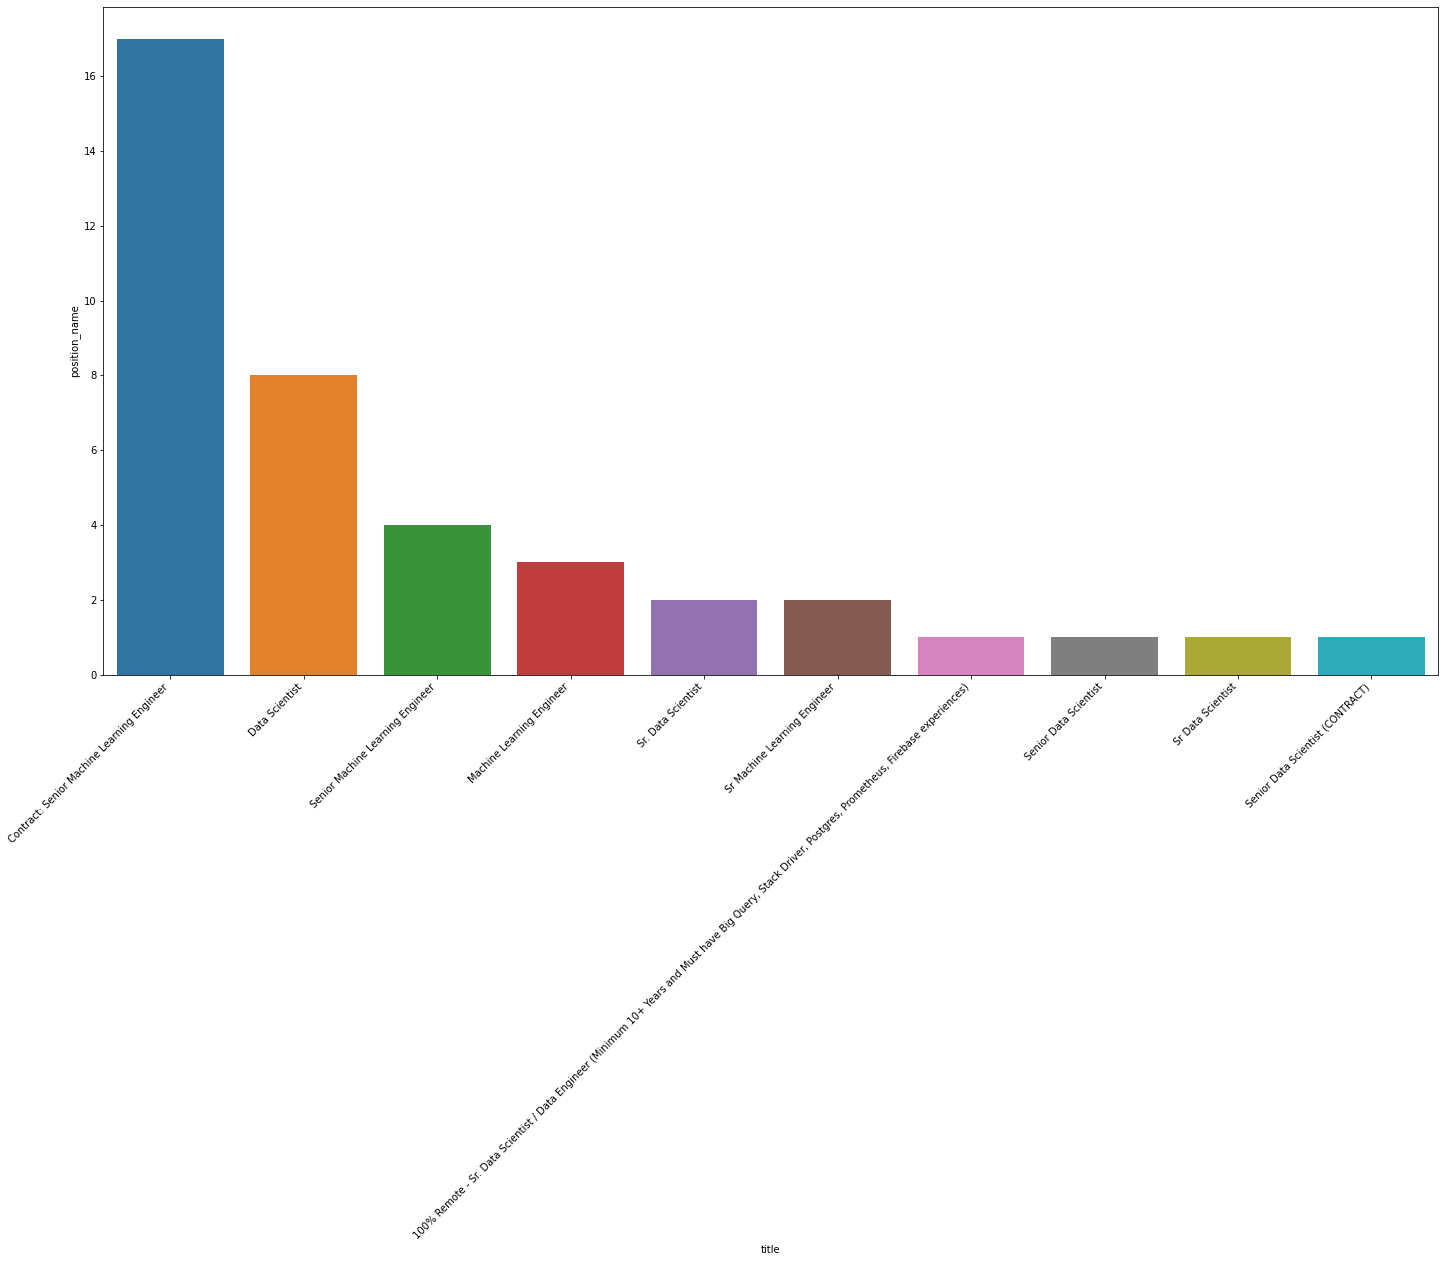

In [141]:
top_10_jobs_name = df_target.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)
plt.figure(figsize=(20,10))
sns.barplot(x = top_10_jobs_name.index , y = top_10_jobs_name)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')

Experiences required

In [142]:
df_target.groupby('experience_required').count()['title'].sort_values(ascending=False)

experience_required
Mid-Senior level    48
Name: title, dtype: int64

All contract type

In [143]:
df_target.groupby('contract_type').count()['title'].sort_values(ascending=False)

contract_type
Contract     47
Temporary     1
Name: title, dtype: int64

All different Function names

In [144]:
df_target.groupby('function_name').count()['title'].sort_values(ascending=False)

function_name
Engineering and Information Technology               33
Information Technology                                9
Engineering                                           2
Analyst and Science                                   1
Information Technology and Engineering                1
Information Technology, Engineering, and Research     1
Management, Sales, and Strategy/Planning              1
Name: title, dtype: int64

All different company sectors

In [145]:
df_target.groupby('company_sector').count()['title'].sort_values(ascending=False)

company_sector
Technology, Information and Internet and Human Resources Services                          17
Staffing and Recruiting                                                                     7
IT Services and IT Consulting                                                               6
Software Development                                                                        2
Advertising Services                                                                        1
IT Services and IT Consulting, Banking, and Accounting                                      1
Technology, Information and Internet                                                        1
Staffing and Recruiting and Financial Services                                              1
Machinery Manufacturing                                                                     1
IT Services and IT Consulting, Software Development, and Research Services                  1
IT Services and IT Consulting and Hospitals a

All different locations

In [146]:
df_target.groupby('location').count()['title'].sort_values(ascending=False)

location
United States                      14
California, United States           2
New York, United States             2
New York, NY                        2
Arizona, United States              1
New York City Metropolitan Area     1
Texas, United States                1
Tennessee, United States            1
Seattle, WA                         1
San Francisco, CA                   1
San Francisco Bay Area              1
Redmond, WA                         1
Pleasanton, CA                      1
Pennsylvania, United States         1
Oregon, United States               1
Ohio, United States                 1
Nevada, United States               1
Austin, TX                          1
Missouri, United States             1
Minnesota, United States            1
Massachusetts, United States        1
Maryland, United States             1
Illinois, United States             1
Hershey, PA                         1
Helena, MT                          1
Georgia, United States              1
Flo

Example of description

In [154]:
df_target['description'].iloc[0]

"Job Description Summary:The Enterprise Data Science organization drives value for Hershey by creating disruptive predictive and prescriptive solutions to the Enterprise for analytics and decision-making.The Sr. Data Scientist will be working with Hershey business partners, technical engineers, data architects, and project managers to ensure data science standards adhere to company best practice and help to deliver rapid impactful benefits.The Sr. Data Scientist will act as a trusted advisor for Hershey business partners to build new, data-driven, machine-intelligent capabilities that impact the business. You will work with large volumes of data, innovative technologies, and advanced methods to solve real business problems. You'll design and run experiments, research new algorithms, and find new ways of optimizing risk, profitability, and the customer experience. You will work with a diverse team of business analysts, technical engineers, data architects, and project managers to delive

In [153]:
df_target['description'].iloc[1]

'Dice is the leading career destination for tech experts at every stage of their careers. Our client, Tech Affinity Inc, is seeking the following. Apply via Dice today!Title: Sr. Data Scientist/ Data Engineer Location: 100% Remote Duration: 1 Year Looking for a Data Scientist/Data Engineer with the ability to do queries for the following.Big Query Stack Driver Postgres Prometheus Firebase An example of a solution We have debug data feeding from our mobile application into stack driver which shows the sequence of a user is traversing. It is hard to compute a percentage of successful configuration attempts by our customers.Looking at how the data is coming in and passing from stack driver to Big Query I would expect this person to:Talk to the engineers to understand the application flow and current data being passed up to the cloud.Look at the data being received into cloud Ensure right tools are being used for the task: Stack Driver vs Firebase etc.Request any additional information nee

# Data Science

## Feature engineer

In [158]:
# Create a list of text documents from the dataframe column
texts = df_target['description'].tolist()

# Tokenize the text and remove stop words
texts = [[token for token in gensim.utils.simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS] for text in texts]

# Create a dictionary from the data
dictionary = corpora.Dictionary(texts)

# Convert corpus to bag of words format
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=5,
                                            random_state=42,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

# Print top 5 topics with their corresponding top 5 words
topics = lda_model.print_topics(num_topics=5, num_words=5)
for topic in topics:
    print(topic)

(0, '0.030*"data" + 0.026*"work" + 0.026*"models" + 0.022*"upwork" + 0.019*"team"')
(1, '0.040*"data" + 0.017*"experience" + 0.012*"business" + 0.009*"science" + 0.008*"learning"')
(2, '0.011*"ml" + 0.007*"experience" + 0.007*"engineer" + 0.007*"maxonic" + 0.005*"client"')
(3, '0.037*"data" + 0.022*"experience" + 0.011*"years" + 0.010*"scientist" + 0.009*"analysis"')
(4, '0.026*"experience" + 0.025*"data" + 0.020*"learning" + 0.015*"machine" + 0.010*"models"')


### Create a new column that have all words without stop words

In [162]:
df_target['all_words_clean'] = texts

C:\Users\55249\AppData\Local\Temp\ipykernel_16016\3587034527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['all_words_clean'] = texts


In [164]:
df_target.head()

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,all_words_clean
0,Sr. Data Scientist,"Hershey, PA",PRI Global,Sr. Data Scientist,Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting,Job Description Summary:The Enterprise Data Sc...,https://www.linkedin.com/jobs/view/3478366331,"[job, description, summary, enterprise, data, ..."
16,100% Remote - Sr. Data Scientist / Data Engine...,United States,Dice,100% Remote - Sr. Data Scientist / Data Engine...,Mid-Senior level,Contract,Engineering and Information Technology,"Technology, Information and Internet",Dice is the leading career destination for tec...,https://www.linkedin.com/jobs/view/3478375375,"[dice, leading, career, destination, tech, exp..."
17,Sr Machine Learning Engineer,United States,Burtch Works,Sr Machine Learning Engineer,Mid-Senior level,Contract,Engineering,Software Development,Senior Machine Learning Engineer As a Senior M...,https://www.linkedin.com/jobs/view/3184133160,"[senior, machine, learning, engineer, senior, ..."
18,Sr. Data Scientist,United States,Insight Global,Sr. Data Scientist,Mid-Senior level,Contract,Information Technology,Broadcast Media Production and Distribution an...,Position: Sr. Data Scientist Duration: 12 mon...,https://www.linkedin.com/jobs/view/3472342299,"[position, sr, data, scientist, duration, mont..."
20,Senior Machine Learning Engineer,"New York, United States",InterEx Group,Senior Machine Learning Engineer,Mid-Senior level,Contract,Engineering and Information Technology,Staffing and Recruiting,Senior Role The ideal candidate's favourite wo...,https://www.linkedin.com/jobs/view/3476849156,"[senior, role, ideal, candidate, favourite, wo..."


### Extract years of experience required in description

Using regex

In [169]:

# Define regular expression pattern to match the number of years
pattern = r'(\d+)\+?\s*(years|year|yrs|yr)'
matches = df_target['description'].apply(lambda x: re.findall(pattern, x, re.IGNORECASE))

In [180]:
matches

0                                                     []
16                              [(1, Year), (10, years)]
17                                          [(5, years)]
18                                          [(5, years)]
20                                          [(4, years)]
21                              [(6, years), (6, years)]
23                                          [(5, years)]
24                                          [(3, years)]
25     [(10, years), (4, years), (10, year), (3, year...
27                                          [(2, years)]
28                  [(5, years), (5, years), (5, years)]
29                                          [(2, years)]
30                                          [(4, years)]
31                                          [(8, years)]
32     [(31, years), (2, years), (7, years), (7, year...
33                              [(3, years), (5, years)]
430                                                   []
448                            

In [179]:
# Extract the matched numbers and convert them to integers
matches.apply(lambda x: [int(match[0]) for match in x])

0                                     []
16                               [1, 10]
17                                   [5]
18                                   [5]
20                                   [4]
21                                [6, 6]
23                                   [5]
24                                   [3]
25                     [10, 4, 10, 3, 2]
27                                   [2]
28                             [5, 5, 5]
29                                   [2]
30                                   [4]
31                                   [8]
32             [31, 2, 7, 7, 7, 7, 3, 3]
33                                [3, 5]
430                                   []
448                                   []
510                                   []
514                                   []
516                                  [5]
521                                   []
523                                  [5]
524    [4, 5, 5, 7, 5, 3, 3, 5, 5, 5, 5]
525             

In [178]:
df_target['description'][864]

'Upwork ($UPWK) is the world’s work marketplace. We serve everyone from one-person startups to over 30% of the Fortune 100 with a powerful, trust-driven platform that enables companies and talent to work together in new ways that unlock their potential.Last year, more than $3.3 billion of work was done through Upwork by skilled professionals who are gaining more control by finding work they are passionate about and innovating their careers.This is an engagement through Upwork’s Hybrid Workforce Solutions (HWS) Team. Our Hybrid Workforce Solutions Team is a global group of professionals that support Upwork’s business. Our HWS team members are located all over the world.This Senior ML Engineer will work alongside our Trust and Safety ML Team to build a model suite to detect and disrupt payment fraud.Work/Project Scope:Real-time production machine learning engineering in a cloud environment (Amazon AWS Sagemaker). Prepare and clean data; develop ML features; train and evaluate models; pro

Using entity recognition model "Spacy"

In [5]:
import spacy
import random

In [6]:
df_target

NameError: name 'df_target' is not defined

In [ ]:
# Define the training data
TRAIN_DATA = [
    ("I want to order a pizza from Pizza Palace", {"entities": [(23, 35, "RESTAURANT")]}),
    ("Get me a burger from Burger Queen", {"entities": [(15, 25, "RESTAURANT")]}),
    ("I'm craving sushi from Sushi Spot", {"entities": [(20, 31, "RESTAURANT")]}),
    ("I want a sandwich from Submarine Sandwiches", {"entities": [(16, 38, "RESTAURANT")]}),
    ("Order me a coffee from Starbucks", {"entities": [(19, 28, "RESTAURANT")]}),
    ("I want a burger and fries from McDonald's", {"entities": [(20, 30, "RESTAURANT")]}),
    ("Get me a burrito from Chipotle", {"entities": [(14, 22, "RESTAURANT")]}),
    ("I'm in the mood for pizza from Papa John's", {"entities": [(24, 35, "RESTAURANT")]}),
]

# Define the function to train the model
def train_model(nlp, train_data, n_iter=100):
    # Create a new entity recognizer
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    else:
        ner = nlp.get_pipe("ner")
    
    # Add the new label to the entity recognizer
    ner.add_label("RESTAURANT")
    
    # Disable other pipeline components during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):
        # Initialize the optimizer
        optimizer = nlp.begin_training()
        for i in range(n_iter):
            # Shuffle the training data for each iteration
            random.shuffle(train_data)
            losses = {}
            for text, annotations in train_data:
                # Update the model with each text-annotation pair
                nlp.update([text], [annotations], sgd=optimizer, losses=losses)
            print(f"Iteration {i+1}: Losses = {losses}")
    
    return nlp

# Train the model
nlp = spacy.blank("en")
nlp = train_model(nlp, TRAIN_DATA)

# Test the model on some example text
text = "I want to order a pizza from Pizza Hut"
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)
